# Conditional Variational Autoencoder (CVAE) Project
This notebook implements a Conditional Variational Autoencoder (CVAE) for generating images conditioned on specific labels using the MNIST dataset. The CVAE combines deep learning with probabilistic methods to enable controlled image generation.

## Step 1: Data Preparation
Load and preprocess the MNIST dataset. Normalize image pixel values to [0, 1] and one-hot encode the labels to use as conditions.

In [1]:

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images to range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape images to add a channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# One-hot encode the labels
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=10)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 2: Build the Encoder
The encoder processes the input image and condition, then outputs the latent space parameters (mean and log variance).

In [2]:

from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Conv2D
from tensorflow.keras.models import Model

# Latent space size
latent_dim = 2

# Encoder model
def build_encoder():
    image_input = Input(shape=(28, 28, 1), name="image_input")
    label_input = Input(shape=(10,), name="label_input")

    # Process image
    x = Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(image_input)
    x = Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = Flatten()(x)

    # Concatenate image features with label
    x = Concatenate()([x, label_input])
    x = Dense(128, activation="relu")(x)

    # Output latent parameters
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    return Model([image_input, label_input], [z_mean, z_log_var], name="encoder")


## Step 3: Latent Space Sampling
The reparameterization trick is used to sample from the latent space.

In [3]:

import tensorflow.keras.backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


## Step 4: Build the Decoder
The decoder reconstructs the image from the latent variable and condition.

In [4]:

from tensorflow.keras.layers import Reshape, Conv2DTranspose

def build_decoder():
    latent_input = Input(shape=(latent_dim,), name="latent_input")
    label_input = Input(shape=(10,), name="label_input")

    # Concatenate latent variable with label
    x = Concatenate()([latent_input, label_input])
    x = Dense(7 * 7 * 64, activation="relu")(x)
    x = Reshape((7, 7, 64))(x)

    # Upsample to reconstruct image
    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

    return Model([latent_input, label_input], x, name="decoder")


## Step 5: Build the CVAE
Combine the encoder, latent sampling, and decoder to create the CVAE model.

In [7]:
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, Conv2D, Lambda # Added Lambda import
from tensorflow.keras.models import Model

# ... (rest of the code remains the same)
# Instantiate encoder and decoder
encoder = build_encoder()
decoder = build_decoder()

# Define the CVAE model
image_input = Input(shape=(28, 28, 1))
label_input = Input(shape=(10,))

# Encode to latent space
z_mean, z_log_var = encoder([image_input, label_input])
z = Lambda(sampling, name="z_sampling")([z_mean, z_log_var])

# Decode latent space to reconstruct image
reconstructed = decoder([z, label_input])

# Define the CVAE model
cvae = Model([image_input, label_input], reconstructed, name="cvae")


## Step 6: Loss Function
The loss combines reconstruction loss and KL divergence.

In [23]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

# Define a custom layer for adding the KL divergence to the loss
class KLLossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(KLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return z_mean  # Passing z_mean downstream

# Rebuild the CVAE with the KL divergence as part of the graph
z_mean, z_log_var = encoder([image_input, label_input])
z_mean = KLLossLayer()([z_mean, z_log_var])  # KL loss is added here
z = Lambda(sampling, name="z_sampling")([z_mean, z_log_var])

# Decode latent space to reconstruct image
reconstructed = decoder([z, label_input])

# Define the CVAE model
cvae = Model([image_input, label_input], reconstructed, name="cvae")

# Compile the model with only the reconstruction loss (KL is added automatically)
def reconstruction_loss(y_true, y_pred):
    return mse(K.flatten(y_true), K.flatten(y_pred)) * 28 * 28

cvae.compile(optimizer="adam", loss=reconstruction_loss)


## Step 7: Training
Train the CVAE on the MNIST dataset.

In [24]:

cvae.fit([x_train, y_train_onehot], x_train,
         epochs=50,
         batch_size=128,
         validation_data=([x_test, y_test_onehot], x_test))


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 66.2992 - val_loss: 42.2160
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 42.3275 - val_loss: 41.6750
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 41.9536 - val_loss: 41.7346
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 42.0126 - val_loss: 41.6257
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 41.8823 - val_loss: 41.5369
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 41.8679 - val_loss: 41.5589
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 41.9456 - val_loss: 41.5499
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 41.9179 - val_loss: 41.5396
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 41.8652 - val_loss: 41.5581
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 41.9048 - val_loss: 41.5197
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 41.9215 - val_loss: 41.5664
Epoch 12/50
469/469 ━━━━━━━

## Step 8: Conditional Image Generation
Generate new images by sampling from the latent space and providing specific conditions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


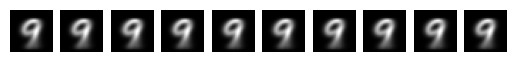

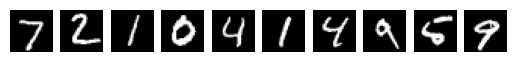

In [27]:

import matplotlib.pyplot as plt

def generate_images(label, num_images=10):
    # Create one-hot encoded label
    condition = np.zeros((num_images, 10))
    condition[:, label] = 1

    # Sample random latent variables
    latent_samples = np.random.normal(size=(num_images, latent_dim))

    # Generate images
    generated_images = decoder.predict([latent_samples, condition])

    # Plot images
    for i, img in enumerate(generated_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Generate images for the digit "7"
generate_images(label=9)


# generate original images
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()
